# BAYESIAN MODEL

# Importing Libraries and Loading Data

In [120]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
# to ignore warnings:
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv("Advertising.csv")

In [5]:
df.head()

,Unnamed: 0,TV,radio,newspaper,sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


In [6]:
df = df.iloc[:,1:len(df)]

In [7]:
df.head()

,TV,radio,newspaper,sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


In [8]:
df.shape

(200, 4)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   radio      200 non-null    float64
 2   newspaper  200 non-null    float64
 3   sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
TV,200.0,147.0425,85.854236,0.7,74.375,149.75,218.825,296.4
radio,200.0,23.2640,14.846809,0.0,9.975,22.90,36.525,49.6
newspaper,200.0,30.5540,21.778621,0.3,12.750,25.75,45.100,114.0
sales,200.0,14.0225,5.217457,1.6,10.375,12.90,17.400,27.0


## Variable Correlations with Sales

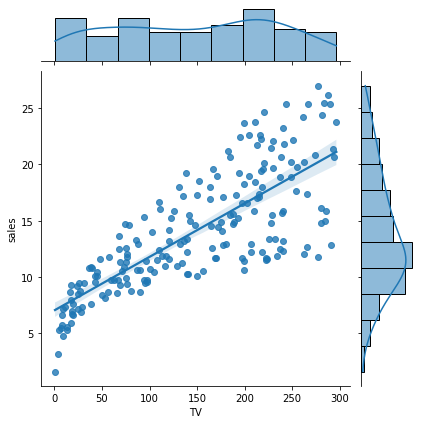

In [11]:
sns.jointplot(x = "TV", y = "sales", data = df, kind = "reg");

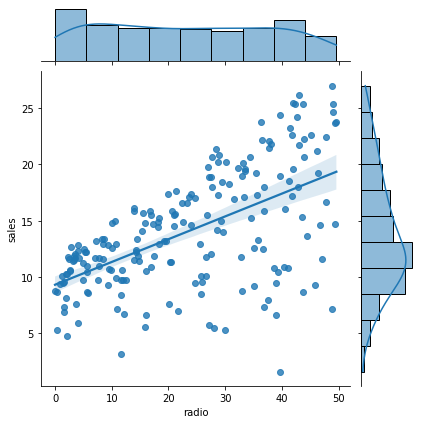

In [114]:
sns.jointplot(x = "radio", y = "sales", data = df, kind = "reg");

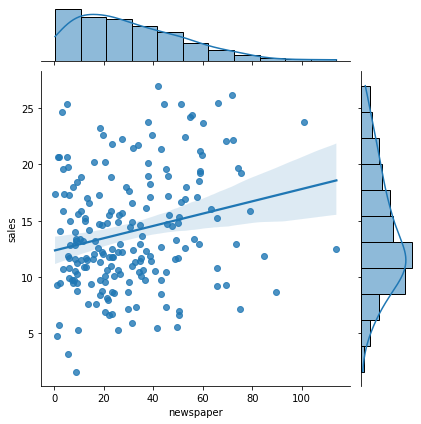

In [115]:
sns.jointplot(x = "newspaper", y = "sales", data = df, kind = "reg");

In [12]:
df.corr()['sales'].sort_values()

newspaper    0.228299
radio        0.576223
TV           0.782224
sales        1.000000
Name: sales, dtype: float64

# Modeling

In [13]:
y = df[["sales"]]

In [14]:
X = df[["TV","radio","newspaper"]]

In [15]:
 # Spliting the train data
 X_train, X_test, y_train, y_test = train_test_split(df, y, 
                                                        test_size = 0.25,
                                                        random_state=42)

In [16]:
X_train.head()

,TV,radio,newspaper,sales
114,78.2,46.8,34.5,14.6
173,168.4,7.1,12.8,11.7
5,8.7,48.9,75.0,7.2
126,7.8,38.9,50.6,6.6
117,76.4,0.8,14.8,9.4


In [17]:
print(X_train.shape)
print(X_test.shape)

(150, 4)
(50, 4)


In [18]:
# Formula for Bayesian Linear Regression 
formula = 'sales ~ ' + ' + '.join(['%s' % variable for variable in X_train.columns[:-1]])
formula

'sales ~ TV + radio + newspaper'

## Create Model in PyMC3 and Sample from Posterior

In [121]:
# Context for the model
with pm.Model() as normal_model:
    
    # The prior for the model parameters will be a normal distribution
    family = pm.glm.families.Normal()
    
    # Creating the model requires a formula and data (and optionally a family)
    pm.GLM.from_formula(formula, data = df, family = family)
    
    # Perform Markov Chain Monte Carlo sampling
    normal_trace = pm.sample(draws=2000, chains = 2, tune = 500)

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, newspaper, radio, TV, Intercept]


Sampling 2 chains for 500 tune and 2_000 draw iterations (1_000 + 4_000 draws total) took 15 seconds.
The acceptance probability does not match the target. It is 0.8854867799248384, but should be close to 0.8. Try to increase the number of tuning steps.


## Traceplot of All Samples

In [123]:
# Shows the trace with a vertical line at the mean of the trace
def plot_trace(trace):
    # Traceplot with vertical lines at the mean value
    ax = pm.traceplot(trace, figsize=(18, len(trace.varnames)*3),
                      lines={k: v['mean'] for k, v in az.summary(trace).iterrows()})
    
    matplotlib.rcParams['font.size'] = 20
    
    # Labels with the median value
    for i, mn in enumerate(az.summary(trace)['mean']):
        ax[i, 0].annotate('{:0.2f}'.format(mn), xy = (mn, 0), xycoords = 'data', size = 8,
                          xytext = (-18, 18), textcoords = 'offset points', rotation = 90,
                          va = 'bottom', fontsize = 'large', color = 'red')

### The posterior distributions and traces for all parameters

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


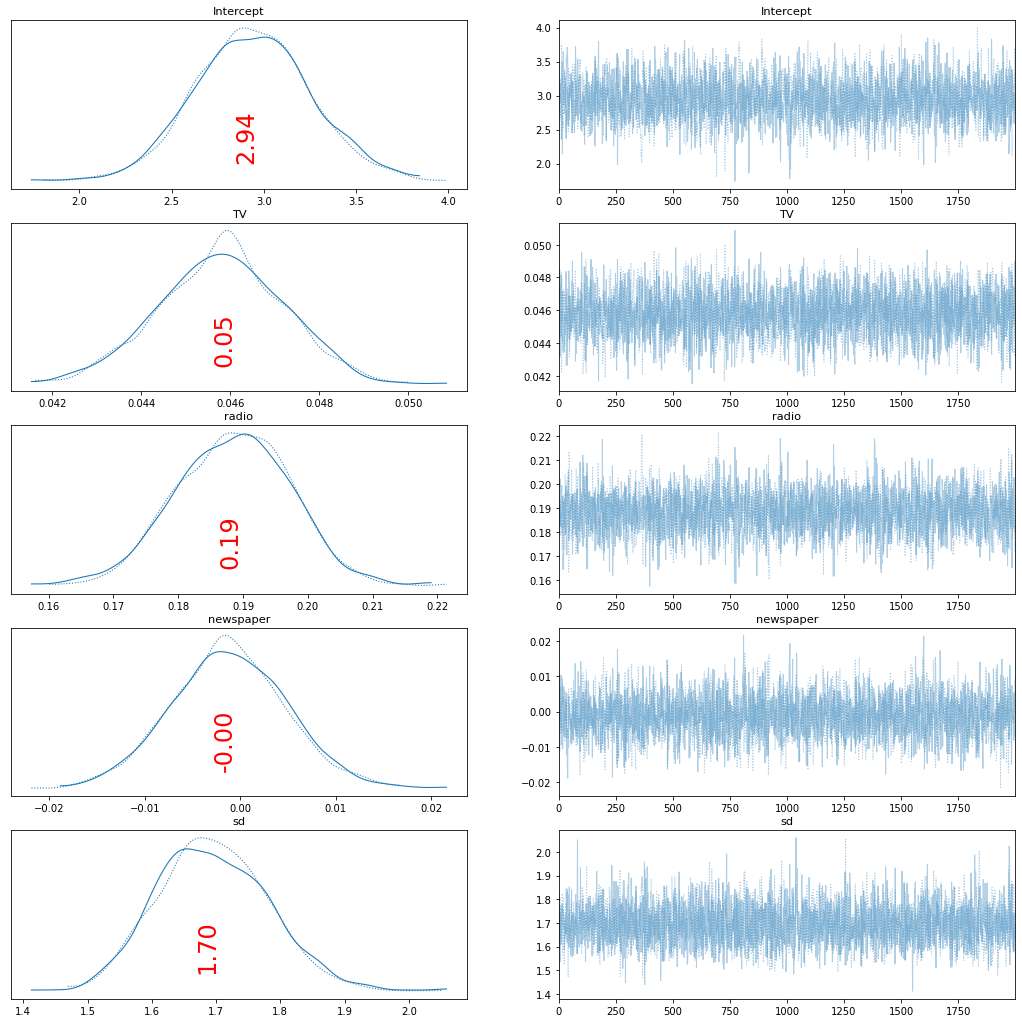

In [124]:
plot_trace(normal_trace);

The left side of the traceplot is the marginal posterior: the values for the variable are on the x-axis with the probability for the variable (as determined by sampling) on the y-axis. The different colored lines indicate that we performed two chains of Markov Chain Monte Carlo. From the left side we can see that there is a range of values for each weight. The right side shows the different sample values drawn as the sampling process runs.

Got error No model on context stack. trying to find log_likelihood in translation.


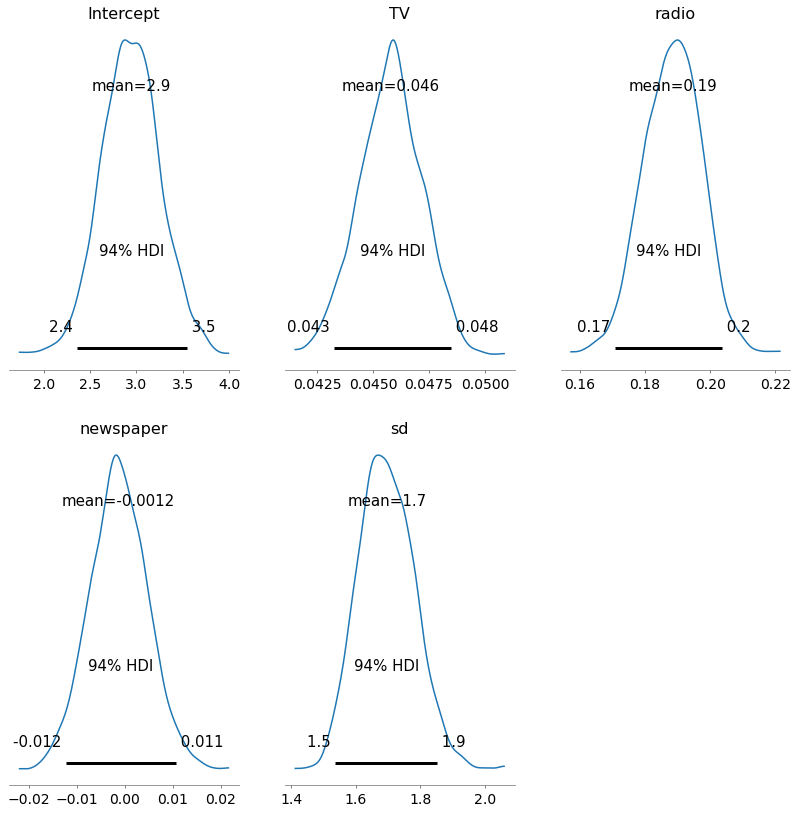

In [125]:
pm.plot_posterior(normal_trace, figsize = (14, 14));

### Print out the mean variable weight from the trace

In [65]:
for variable in normal_trace.varnames:
    print('Variable: {:15} Mean weight in model: {:.4f}'.format(variable, 
                                                                np.mean(normal_trace[variable])))

Variable: Intercept       Mean weight in model: 2.9475
Variable: TV              Mean weight in model: 0.0457
Variable: radio           Mean weight in model: 0.1885
Variable: newspaper       Mean weight in model: -0.0010
Variable: sd_log__        Mean weight in model: 0.5248
Variable: sd              Mean weight in model: 1.6924


### Implementing Bayesian Linear Regression

In [67]:
model_formula = 'Sales = '
for variable in normal_trace.varnames:
    model_formula += ' %0.2f * %s +' % (np.mean(normal_trace[variable]), variable)

' '.join(model_formula.split(' ')[:-1])

'Sales =  2.95 * Intercept + 0.05 * TV + 0.19 * radio + -0.00 * newspaper + 0.52 * sd_log__ + 1.69 * sd'

## Make Predictions from Model

### The function to plot the predicted mean value as well as credible bands for it

In [103]:
# Make a new prediction from the test set and compare to actual value
def test_model(trace, test_observation):
    
    # Print out the test observation data
    print('Test Observation:')
    print(test_observation)
    var_dict = {}
    for variable in trace.varnames:
        var_dict[variable] = trace[variable]

    # Results into a dataframe
    var_weights = pd.DataFrame(var_dict)
    
    # Standard deviation of the likelihood
    sd_value = var_weights['sd'].mean()

    # Actual Value
    actual = test_observation['sales']
    
    # Add in intercept term
    test_observation['Intercept'] = 1
    test_observation = test_observation.drop('sales')
    
    # Align weights and test observation
    var_weights = var_weights[test_observation.index]

    # Means for all the weights
    var_means = var_weights.mean(axis=0)

    # Location of mean for observation
    mean_loc = np.dot(var_means, test_observation)
    
    # Estimates of sales
    estimates = np.random.normal(loc = mean_loc, scale = sd_value,
                                 size = 1000)

    # Plot all the estimates
    plt.figure(figsize=(15, 6))  #figsize(8, 8)
    sns.distplot(estimates, hist = True, kde = True, bins = 19,
                 hist_kws = {'edgecolor': 'k', 'color': 'darkblue'},
                kde_kws = {'linewidth' : 2},
                label = 'Estimated Dist.')
    # Plot the actual sales
    plt.vlines(x = actual, ymin = 0, ymax = 0.5, 
               linestyles = '--', colors = 'red',
               label = 'True sales',
              linewidth = 1.5)
    
    # Plot the mean estimate
    plt.vlines(x = mean_loc, ymin = 0, ymax = 0.5, 
               linestyles = '-', colors = 'orange',
               label = 'Mean Estimate',
              linewidth = 1.5)
    
    plt.legend(loc = 1)
    plt.title('Density Plot for Test Observation');
    plt.xlabel('sales'); plt.ylabel('Density');
    
    # Prediction information
    print('True sales = %d' % actual)
    print('Average Estimate = %0.4f' % mean_loc)
    print('5%% Estimate = %0.4f    95%% Estimate = %0.4f' % (np.percentile(estimates, 5),
                                       np.percentile(estimates, 95)))

Test Observation:
TV           229.5
radio         32.3
newspaper     74.2
sales         19.7
Name: 124, dtype: float64
True sales = 19
Average Estimate = 19.4452
5% Estimate = 16.6610    95% Estimate = 22.3272


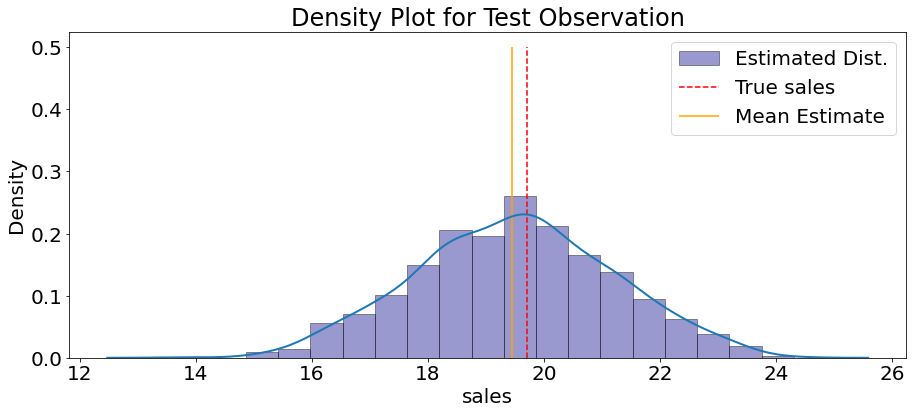

In [126]:
test_model(normal_trace, X_test.iloc[20])

Test Observation:
TV           177.0
radio          9.3
newspaper      6.4
sales         12.8
Name: 197, dtype: float64
True sales = 12
Average Estimate = 12.7889
5% Estimate = 10.0824    95% Estimate = 15.4686


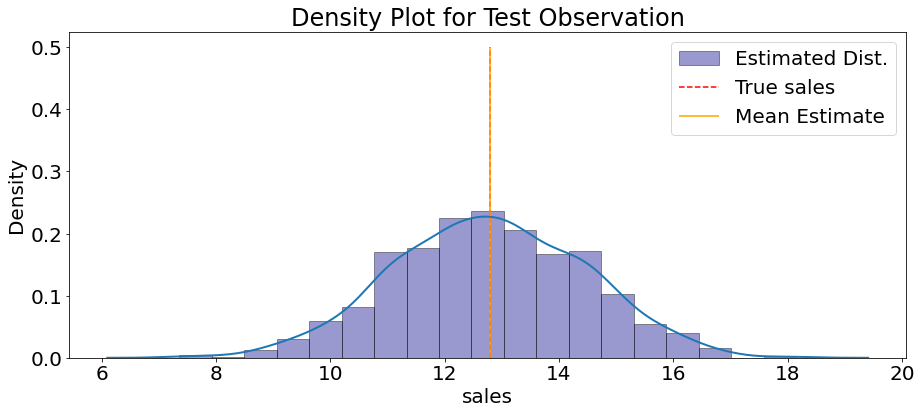

In [127]:
test_model(normal_trace, X_test.iloc[41])

## Predictions for New Observation

In [112]:
# Make predictions for a new data point from the model trace
def query_model(trace, new_observation):
    
    # Print information about the new observation
    print('New Observation')
    print(new_observation)
    # Dictionary of all sampled values for each parameter
    var_dict = {}
    for variable in trace.varnames:
        var_dict[variable] = trace[variable]
        
    # Standard deviation
    sd_value = var_dict['sd'].mean()
    
    # Results into a dataframe
    var_weights = pd.DataFrame(var_dict)
    
    # Align weights and new observation
    var_weights = var_weights[new_observation.index]
    
    # Means of variables
    var_means = var_weights.mean(axis=0)
    
    # Mean for observation
    mean_loc = np.dot(var_means, new_observation)
    
    # Distribution of estimates
    estimates = np.random.normal(loc = mean_loc, scale = sd_value,
                                 size = 1000)
    
    # Plot the estimate distribution
    plt.figure(figsize(15, 8))
    sns.distplot(estimates, hist = True, kde = True, bins = 19,
                 hist_kws = {'edgecolor': 'k', 'color': 'darkblue'},
                kde_kws = {'linewidth' : 4},
                label = 'Estimated Dist.')
    # Plot the mean estimate
    plt.vlines(x = mean_loc, ymin = 0, ymax = 0.5, 
               linestyles = '-', colors = 'orange', linewidth = 2.5)
    plt.title('Density Plot for New Observation');
    plt.xlabel('sales'); plt.ylabel('Density');
    
    # Estimate information
    print('Average Estimate = %0.4f' % mean_loc)
    print('5%% Estimate = %0.4f    95%% Estimate = %0.4f' % (np.percentile(estimates, 5),
                                       np.percentile(estimates, 95)))

New Observation
Intercept      2.9475
TV           300.0000
radio        120.0000
newspaper    400.0000
dtype: float64
Average Estimate = 44.5303
5% Estimate = 41.6245    95% Estimate = 47.2745


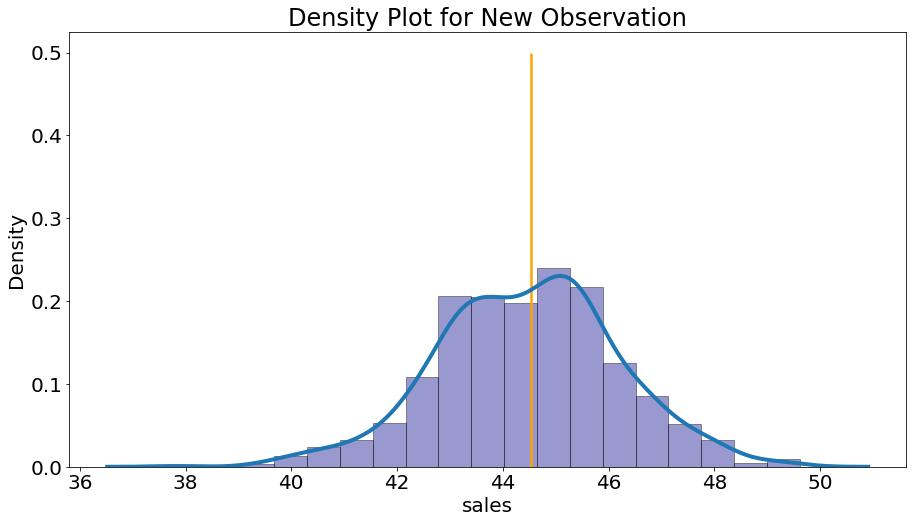

In [128]:
observation = pd.Series({'Intercept': 2.9475, 'TV': 300, 'radio': 120, 
                            'newspaper': 400})
query_model(normal_trace, observation)